Ce notebook montre une application du code utilisé pour entrainer nos CNN pour un dummy dataset composé de 10 valeurs d'entrainement et 10 valeurs de test.

On charge tout d'abord les training set and testing set.

In [6]:
import pandas as pd

train_data = pd.read_pickle('dummy_train.pkl')
test_data = pd.read_pickle('dummy_test.pkl')

print(f"Train data ({len(train_data)}) : {train_data}")
print(f"Test data ({len(test_data)}) : {test_data}")

Train data (10) : [('AGCTATGCGC', -0.32305049896240234, '.((.....))', 1), ('GGCCCTCGGC', -1.3487296104431152, '.(((...)))', 1), ('CTAAGTAATT', -0.5292420387268066, '..((....))', 1), ('ATACGAAGTC', -1.2987360954284668, '..((...)).', 1), ('CGTTCGCGGA', -0.4556596279144287, '((....))..', 1), ('CGCGATTACG', -0.5568556785583496, '..((....))', 1), ('GCGTAAGTTT', -0.6135748624801636, '.(....)...', 1), ('GAGCTGAGCT', -0.7820825576782227, '.(((...)))', 1), ('TACGAAGTCC', -1.2987360954284668, '.((...))..', 1), ('GCCGCTGCGG', -1.3968558311462402, '.(((...)))', 1)]
Test data (10) : [('GGGGGGCCCA', -1.1445636749267578, '(((...))).', 1), ('TGCGTCTCGA', -0.6018104553222656, '..((...)).', 1), ('GAGTAGACTC', -0.07999992370605469, '(((....)))', 1), ('CCGGGTCCCG', -1.2504892349243164, '.(((...)))', 1), ('CGGCACGTTC', -1.2967193126678467, '((...))...', 1), ('ACCGGGCACC', -0.960355281829834, '...((...))', 1), ('CGGCTTACGC', -0.4228684902191162, '((.....)).', 1), ('GCACCCAGCC', -0.5414896011352539, '((.....

Nous convertissons d'abord les séquences (et structures secondaires) en représentation 2D. Il faut également séparer ces séquences en batch pour pouvoir entrainer le modèle sans surcharger la RAM.

Nous utilisons ici un batch size de 5, nous aurons donc 2 batch pour nos 10 données. Ces batches sont stockés dans le fichier batch

In [3]:
#@title Preprocessing - Batching the data
import model_utils as mu

file_path = 'dummy_train.pkl'
batch_size = 5

print("Batching for MFE/n")
mu.process_and_save_batches(file_path, batch_size, output_type = "mfe")

print("/nBatching for Secondary Structure/n")
mu.process_and_save_batches(file_path, batch_size, output_type = "struct")

Batch 1/2 processed and saved.
Batch 2/2 processed and saved.
Batch 1/2 processed and saved.
Batch 2/2 processed and saved.


Les architectures des modèles utilisés sont différentes dépendamment du type de donnée à prédire. Dans le cas des MFE (Float) et hairpins (Int), on utilise SimpleCNN(). Pour les structures secondaires (Matrice 2D) on utilise StructureCNN().

Lors du training, on load les batches d'images nécessaires en mémoire.L'entrainement du model est lent, il nous fallait donc plusieurs sessions de training. Pour la prédiction des MFE (float) et hairpins (int) nous utilisons MSE (Mean Squared Error) comme loss. Pour la prédiction des structures secondaires, nous utilisons BCE (Binary Cross Entropy).

In [4]:
#@title Train model mfe
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

model_mfe = mu.SimpleCNN().to(device)

criterion_mfe = torch.nn.MSELoss()

optimizer_mfe = torch.optim.Adam(model_mfe.parameters(), lr=1e-4, weight_decay=1e-6)

print("Training Model on MFE (Minimum Free Energy) : \n")
mu.train_model_from_batches('batches_mfe', model_mfe, criterion_mfe, optimizer_mfe, num_epochs = 10, output_type = "mfe")

Using device: cpu

Training Model on MFE (Minimum Free Energy) : 


Epoch [1/10], Average Loss: 0.354296, Average val loss: 1.113998
Epoch [2/10], Average Loss: 0.577345, Average val loss: 1.093996
Epoch [3/10], Average Loss: 0.356083, Average val loss: 1.116817
Epoch [4/10], Average Loss: 0.319538, Average val loss: 1.055966
Epoch [5/10], Average Loss: 0.202319, Average val loss: 0.986756
Epoch [6/10], Average Loss: 0.231747, Average val loss: 0.935744
Epoch [7/10], Average Loss: 0.271999, Average val loss: 0.943447
Epoch [8/10], Average Loss: 0.100504, Average val loss: 1.010466
Epoch [9/10], Average Loss: 0.137114, Average val loss: 1.005588
Epoch [10/10], Average Loss: 0.033377, Average val loss: 0.929137

In [4]:
#@title Train model struct
model_struct = mu.StructureCNN(num_channels=5, output_size=60).to(device)

criterion_struct = torch.nn.BCELoss()

optimizer_struct = torch.optim.Adam(model_struct.parameters(), lr=1e-4, weight_decay=1e-6)

print("\nTraining Model on Secondary Structure : \n")
mu.train_model_from_batches('batches_struct', model_struct, criterion_struct, optimizer_struct, num_epochs = 10, batch_size = 1, output_type = "struct")


Training Model on Secondary Structure : 


Epoch [1/10], Average Loss: 0.677034, Average val loss: 0.684669
Epoch [2/10], Average Loss: 0.545403, Average val loss: 0.618457
Epoch [3/10], Average Loss: 0.359363, Average val loss: 0.452941
Epoch [4/10], Average Loss: 0.193215, Average val loss: 0.249302
Epoch [5/10], Average Loss: 0.102321, Average val loss: 0.099663
Epoch [6/10], Average Loss: 0.046348, Average val loss: 0.030091
Epoch [7/10], Average Loss: 0.023466, Average val loss: 0.008817
Epoch [8/10], Average Loss: 0.019314, Average val loss: 0.004044
Epoch [9/10], Average Loss: 0.011518, Average val loss: 0.003244
Epoch [10/10], Average Loss: 0.013338, Average val loss: 0.003247

Une fois les modèles entrainés, on les test sur l'ensemble de test.
On applique d'abord le preprocessing sur les données de test (Séquence vers image + padding et structure vers image + padding).

In [7]:
#@title Preprocess test data

# Features
data_X = [mu.convert_to_pairings(seq[0]) for seq in test_data]
data_X = [mu.pad_structure(matrix, (60, 60), 5) for matrix in data_X]

# Labels
data_Y_mfe = [seq[1] for seq in test_data]
data_Y_hairpins = [seq[3] for seq in test_data]

data_Y_struct = [mu.structure_to_matrix(seq[2]) for seq in test_data]
data_Y_struct = [mu.pad_structure(matrix, (60, 60)) for matrix in data_Y_struct]

On calcule ensuite les prédictions du modèle sur nos ensembles de tests séparés.

On calcule d'abord les métriques pour le modèle MFE.


 Printing metrics for the model : {output_type} 

MSE for data: 0.5533071
MAE for data: 0.62824345
RMSE for data: 0.7438462
R2 for data: -2.33516404834774


/content/model_utils.py:377: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  features_tensor = torch.tensor(features, dtype=torch.float32)


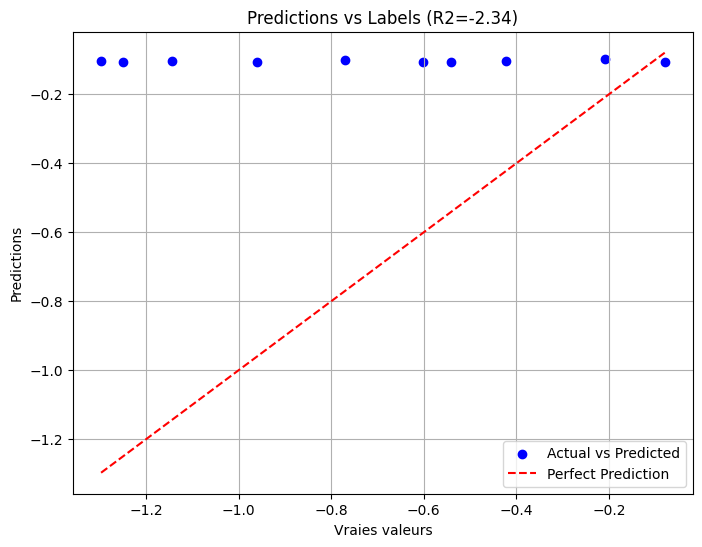

In [7]:
pred_data_mfe,actual_data_mfe = mu.evaluate_model(model_mfe, features = data_X, labels = data_Y_mfe)

mu.get_metrics(pred_data_mfe,actual_data_mfe, output_type = "mfe")

On calcule ensuite les métriques pour le modèle structure.
Les performances sur nos ensembles dummy sont médiocres (le modèle ne peut pas apprendre sur des ensembles de données aussi petits), mais ce code donne cependant une overview du fonctionnement de notre code principal.

In [20]:
pred_data_struct,actual_data_struct = mu.evaluate_model(model_struct, features = data_X, labels = data_Y_struct,isStruct=True)

mu.get_metrics(pred_data_struct,actual_data_struct, output_type = "struct")


 Printing metrics for the model : {output_type} 

Precision :  0.0
Metrics for pred_data:
Symbol '.', Precision: 0.9338983050847458 Recall: 0.9981884057971014 F1 Score: 0.9649737302977233
Symbol '(', Precision: 0.0 Recall: 0.0 F1 Score: 0.0
Symbol ')', Precision: 0.9 Recall: 0.375 F1 Score: 0.5294117647058825


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On peut regarder l'output de notre modèle :

In [21]:
print(pred_data_struct[0])
print(actual_data_struct[0])

........)...................................................
(((...)))...................................................
